# Inversion-Recovery Spin Echo (IRSE) Sequence
This script can be used for both qualitative and quantitative acquisitions.
Input custom parameters to the function `irse_interleaved_split_gradient` to obtain the PyPulseq `seq` obejct. It can then be downloaded after running `seq.write()`.
* The sequence uses an interleaved multislice scheme with random slice order
* Gradients are split in order to merge adjacent gradient ramps to save time
* Change TI and use a long TR for T1 mapping purposes

Questions regarding the sequence itself should be directed to gt2407@columbia.edu;  if you have questions about the PyPulseq package, seek resolution at its own repository (https://github.com/imr-framework/pypulseq/).


## **INSTALLATION**

In [ ]:
#!pip install git+https://github.com/imr-framework/pypulseq.git@1.2.0post4
!pip show pypulseq || pip install pypulseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.5 MB/s eta 0:00:00


Run the following section twice to correctly import all modules

In [ ]:
# Import functions
import copy
from math import pi
import math
import warnings
import numpy as np
np.float = float
np.complex = complex
import pypulseq as pp
#from pypulseq.Sequence.sequence import Sequence
#from pypulseq.calc_duration import calc_duration
#from pypulseq.make_adc import make_adc
# from pypulseq.make_delay import make_delay
# from pypulseq.make_sinc_pulse import make_sinc_pulse
# from pypulseq.make_trap_pulse import make_trapezoid
# from pypulseq.opts import Opts
# from pypulseq.calc_rf_center import calc_rf_center
# from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from scipy.io import savemat

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


## **FUNCTION FOR CUSTOM IRSE SEQUENCE**
See following sections for usage examples and generate your own sequence.


In [ ]:
# =========
# INTERLEAVED WITH IR
# GT, 07/31/20
# =========
def irse_interleaved_split_gradient(fov:float, n_slices:int, rf_flip:int, slice_thickness:float,
                   Nx:int, Ny:int, TE:float, TR:float, TI:float, enc='xyz', slice_locations=None):
    """
    INPUTS
    ------
    fov : Field-of-View (m)
    n_slices : number of slices
    rf_flip : refocusing/inverting flip angle in degrees (just set this to 180)
    slice_thickness : in meters
    Nx, Ny : matrix size
    TE : Echo Time (seconds)
    TR : Repetition Time (seconds)
    TI : Inversion Time (seconds)
    enc : default 'xyz' means readout in x, phase encoding in y and slice in z
    slice_locations : array of slice locations from isocenter, in meters
    """

    # =========
    # SYSTEM LIMITS
    # =========
    # Set the hardware limits and initialize sequence object
    dG = 250e-6 # Fixed ramp time for all gradients
    system = pp.Opts(max_grad=32, grad_unit='mT/m', max_slew=130, slew_unit='T/m/s',
                  rf_ringdown_time=100e-6, rf_dead_time=100e-6,
                  adc_dead_time=10e-6)
    seq = pp.Sequence(system)

    # =========
    # TIME CALCULATIONS
    # =========
    readout_time = 6.4e-3 + 2 * system.adc_dead_time
    t_ex = 2.5e-3
    t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time
    t_ref = 2e-3
    t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time
    t_sp = 0.5 * (TE - readout_time - t_refwd)
    t_spex = 0.5 * (TE - t_exwd - t_refwd)
    fsp_r = 1
    fsp_s = 0.5

    # =========
    # ENCODING DIRECTIONS
    # ==========
    ch_ro = enc[0]
    ch_pe = enc[1]
    ch_ss = enc[2]


    # =========
    # RF AND GRADIENT SHAPES - BASED ON RESOLUTION REQUIREMENTS : kmax and Npe
    # =========

    # RF Phases
    rf_ex_phase = np.pi / 2
    rf_ref_phase = 0

   # Excitation phase (90 deg)
    flip_ex = 90 * np.pi / 180
    rf_ex, gz, _ = pp.make_sinc_pulse(
    flip_angle=flip_ex,
    duration=t_ex,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=rf_ex_phase,
    system=system,
    return_gz=True
    )
    gs_ex = pp.make_trapezoid(channel=ch_ss, system=system, amplitude=gz.amplitude, flat_time=t_exwd, rise_time=dG)

    # Refocusing (same gradient & RF is used for initial inversion)
    flip_ref = rf_flip * np.pi / 180
    rf_ref, gz, _ = pp.make_sinc_pulse(
    flip_angle=flip_ref,
    duration=t_ref,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=rf_ref_phase,
    use='refocusing',
    system=system,
    return_gz=True
    )
    gs_ref = pp.make_trapezoid(channel=ch_ss, system=system, amplitude=gs_ex.amplitude, flat_time=t_refwd, rise_time=dG)

    ags_ex = gs_ex.area / 2
    gs_spr = pp.make_trapezoid(channel=ch_ss, system=system, area=ags_ex * (1 + fsp_s), duration=t_sp, rise_time=dG)
    gs_spex = pp.make_trapezoid(channel=ch_ss, system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG)

    delta_k = 1 / fov
    k_width = Nx * delta_k

    gr_acq = pp.make_trapezoid(channel=ch_ro, system=system, flat_area=k_width, flat_time=readout_time, rise_time=dG)
    adc = pp.make_adc(num_samples=Nx, duration=gr_acq.flat_time - 40e-6, delay=20e-6)
    gr_spr = pp.make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * fsp_r, duration=t_sp, rise_time=dG)
    gr_spex = pp.make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * (1 + fsp_r), duration=t_spex, rise_time=dG)

    agr_spr = gr_spr.area
    agr_preph = gr_acq.area / 2 + agr_spr
    gr_preph = pp.make_trapezoid(channel=ch_ro, system=system, area=agr_preph, duration=t_spex, rise_time=dG)

    phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

    # Split gradients and recombine into blocks
    gs1_times = [0, gs_ex.rise_time]
    gs1_amp = [0, gs_ex.amplitude]
    gs1 = pp.make_extended_trapezoid(channel=ch_ss, times=gs1_times, amplitudes=gs1_amp)

    gs2_times = [0, gs_ex.flat_time]
    gs2_amp = [gs_ex.amplitude, gs_ex.amplitude]
    gs2 = pp.make_extended_trapezoid(channel=ch_ss, times=gs2_times, amplitudes=gs2_amp)

    gs3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
                gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
    gs3_amp = [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
    gs3 = pp.make_extended_trapezoid(channel=ch_ss, times=gs3_times, amplitudes=gs3_amp)

    gs4_times = [0, gs_ref.flat_time]
    gs4_amp = [gs_ref.amplitude, gs_ref.amplitude]
    gs4 = pp.make_extended_trapezoid(channel=ch_ss, times=gs4_times, amplitudes=gs4_amp)

    gs5_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs5_amp = [gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0]
    gs5 = pp.make_extended_trapezoid(channel=ch_ss, times=gs5_times, amplitudes=gs5_amp)

    gs7_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs7_amp = [0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude]
    gs7 = pp.make_extended_trapezoid(channel=ch_ss, times=gs7_times, amplitudes=gs7_amp)

    gr3 = gr_preph

    gr5_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr5_amp = [0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude]
    gr5 = pp.make_extended_trapezoid(channel=ch_ro, times=gr5_times, amplitudes=gr5_amp)

    gr6_times = [0, readout_time]
    gr6_amp = [gr_acq.amplitude, gr_acq.amplitude]
    gr6 = pp.make_extended_trapezoid(channel=ch_ro, times=gr6_times, amplitudes=gr6_amp)

    gr7_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr7_amp = [gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0]
    gr7 = pp.make_extended_trapezoid(channel=ch_ro, times=gr7_times, amplitudes=gr7_amp)

    t_ex = gs1.tt[-1] + gs2.tt[-1] + gs3.tt[-1]
    t_ref = gs4.tt[-1] + gs5.tt[-1] + gs7.tt[-1] + readout_time
    t_end = gs4.tt[-1] + gs5.tt[-1]




    # =========
    # NUMBER OF SLICES PER TR - ADAPT TO HIGHER TR IF IT DOES NOT FIT
    # =========


    # 1. Without spoilers on each side
    TE_prime = 0.5* pp.calc_duration(gs_ref) + TI + TE + 0.5 * readout_time + np.max([pp.calc_duration(gs7), pp.calc_duration(gr7)]) + \
               pp.calc_duration(gs4) + pp.calc_duration(gs5)

    # 2. With spoilers on each side
    #TE_prime = calc_duration(gs_inv_1) + 0.5 * calc_duration(gs_inv_2) + TI + TE + \
    #           0.5 * readout_time + np.max([calc_duration(gs7), calc_duration(gr7)]) + \
    #           calc_duration(gs4) + calc_duration(gs5)



    ns_per_TR = np.floor(TR / TE_prime)
    print('Number of slices that can be accommodated =' + str(ns_per_TR))

    if (ns_per_TR < n_slices):
      warnings.warn(f'TR too short, adapted to include all slices to: {n_slices * TE_prime + 50e-6} s')
      TR = round(n_slices * TE_prime + 50e-6, ndigits=5)
      print('New TR = ' + str(TR))
      ns_per_TR = np.floor(TR / TE_prime)

    if (n_slices < ns_per_TR):
        ns_per_TR = n_slices

    # randperm so that adjacent slices do not get excited one after the other - TODO : shuffling might be messy for visualization if not indexed
    sl_order = np.random.permutation(n_slices)

    print('Number of slices acquired per TR = ' + str(ns_per_TR))

    # Delays
    TI_fill = TI - (0.5*pp.calc_duration(gs_ref) + pp.calc_duration(gs1) + 0.5*pp.calc_duration(gs2))
    delay_TI = pp.make_delay(TI_fill)
    TR_fill = TR - ns_per_TR * TE_prime
    delay_TR = pp.make_delay(TR_fill)


    if slice_locations is None:
      slice_locations = slice_thickness * (np.arange(n_slices) - (n_slices-1)/2)


    for k_ex in range(Ny):
        phase_area = phase_areas[k_ex]
        gp_pre = pp.make_trapezoid(channel=ch_pe, system=system, area=phase_area, duration=t_sp, rise_time=dG)
        gp_rew = pp.make_trapezoid(channel=ch_pe, system=system, area=-phase_area, duration=t_sp, rise_time=dG)
        s_in_TR = 0

        for s in range(len(sl_order)):

            #rf_ex.freq_offset = gs_ex.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)
            #rf_ref.freq_offset = gs_ref.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)

            rf_ex.freq_offset = gs_ex.amplitude * slice_locations[sl_order[s]]
            rf_ref.freq_offset = gs_ref.amplitude * slice_locations[sl_order[s]]

            rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * pp.calc_rf_center(rf_ex)[0]
            rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * pp.calc_rf_center(rf_ref)[0]

            # Inversion using refocusing pulse
            seq.add_block(gs_ref, rf_ref)
            seq.add_block(delay_TI)

            # SE portion
            seq.add_block(gs1)
            seq.add_block(gs2, rf_ex)
            seq.add_block(gs3, gr3)

            seq.add_block(gs4, rf_ref)

            seq.add_block(gs5, gr5, gp_pre)
            seq.add_block(gr6, adc)

            seq.add_block(gs7, gr7, gp_rew)

            seq.add_block(gs4)
            seq.add_block(gs5)
            s_in_TR += 1
            if (s_in_TR == ns_per_TR):
                seq.add_block(delay_TR)
                s_in_TR = 0

    return seq, sl_order

## RUN FUNCTION TO MAKE SEQUENCE
Run one of the following three subsections to generate the the sequences used for the test experiments.

### Simulation


In [ ]:
# For simulation
n_slices = 1
Nx = 32
Ny = 32
fov = 250 * 1e-3
slice_thickness = 5 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse
              # And excitation is fixed to 90 deg
TE = 12 * 1e-3
TR = 2000 * 1e-3
TI = 100 * 1e-3

enc='xyz' # Axial slices
seq, sl_order = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=slice_thickness,
                                          rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=[0])


Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 1


### Qualitative (ACR slices)

In [ ]:
# Generate seqs for qualitative multislice scan (ACR phantom)
from scipy.io import savemat
Nx = 256
Ny = 256
fov = 250 * 1e-3
thk = 5 * 1e-3
gap = 5 * 1e-3
displacement = 5e-3 # 6th slice location after positioning "nose" mark at isocenter
n_slices = 13 # 11 before; trying to get the extras
L = (n_slices-1)*(thk+gap)
acr_sl_locs = displacement + np.arange(-L/2, L/2 + thk + gap, thk + gap)
print(acr_sl_locs)


rf_flip = 180 # For some reason this value is used for refocusing pulse
              # And excitation is fixed to 90 deg
TE = 12 * 1e-3
TR = 2000 * 1e-3
TI = 100 * 1e-3 # change this!

enc='xyz'
seq, sl_order = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=thk,
                                          rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=acr_sl_locs)
savemat('irse_sl_order.mat',{'sl_order': sl_order})

# Download slice order
from google.colab import files
files.download('irse_sl_order.mat')

[-0.055 -0.045 -0.035 -0.025 -0.015 -0.005  0.005  0.015  0.025  0.035
  0.045  0.055  0.065]
Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### T1 Mapping (NIST T1 array)

In [ ]:
# Generate seqs for T1 mapping
# Set default values
n_slices = 1
Nx = 128
Ny = 128
fov = 250 * 1e-3
slice_thickness = 6 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse
              # And excitation is fixed to 90 deg
TE = 10 * 1e-3
TR = 4500 * 1e-3

# Version without flanking spoilers on inversion
TI_array = 1e-3 * np.array([50, 75, 100, 125, 150, 250, 1000, 1500, 2000, 3000])
# enc='yzx' # x-dir / sagittal slice (the order is readout, phase, slice)
enc='xyz'
for TI in TI_array:
  seq, __ = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=slice_thickness,
                                            rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=[0])
  save_name = f'irse_pypulseq_colab_{n_slices}slices_FOV{fov*1e3}_N{Nx}_TR{TR*1e3}_TE{TE*1e3}_TI{TI*1e3}_thk{slice_thickness*1e3}mm_enc_{enc}.seq'
  seq.set_definition('FOV', [fov, fov, slice_thickness]);
  seq.set_definition('SlicePositions', 0);
  seq.set_definition('SliceThickness', slice_thickness);
  seq.set_definition('SliceGap', 0);
  seq.write(save_name)  # Generate .seq file
  from google.colab import files
  files.download(save_name)  # Download locally

Number of slices that can be accommodated =66.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =48.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =38.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =31.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =26.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =4.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =2.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =2.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =1.0
Number of slices acquired per TR = 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## PLOT THE SEQUENCE
Change the `time_range` (seconds) to view different parts of the sequence.

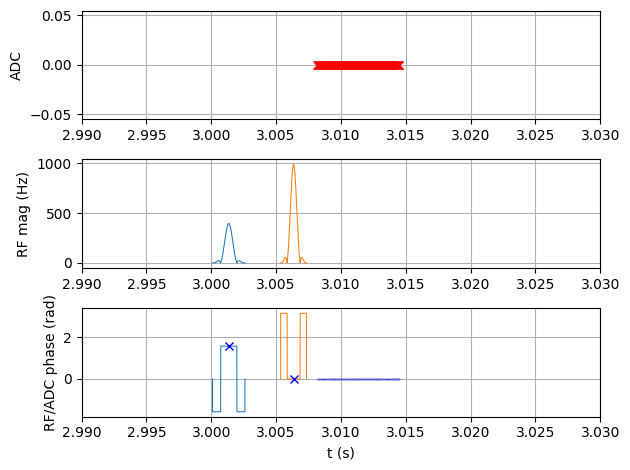

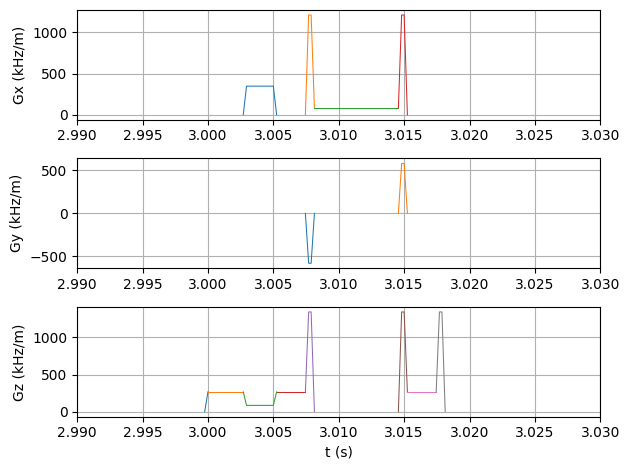

In [ ]:
seq.plot(time_range=(2.99, 3.03))

## USE `seq.test_report()` TO SANITY-CHECK THE SEQUENCE
This takes a long time. It may be skipped if you have validated the files or are trying to generate sequences quickly.

In [ ]:
print(seq.test_report())

Number of blocks: 1536
Number of events:
RF:    384
Gx:    512
Gy:    256
Gz:   1152
ADC:    128
Delay:      0
Sequence duration: 576.000000 s
TE: 0.010000 s
TR: 4.500000 s
Flip angle: 90.00 180.00 deg
Unique k-space positions (aka cols, rows, etc.): 128 128 
Dimensions: 2
Spatial resolution: 1.98 mm
Spatial resolution: 1.95 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check failed. Error listing follows:
 ['Event: 8 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 20 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 32 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 44 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 56 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 68 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 80 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 92 - [type: adc delay: 20.0 us dwell: 49843.75 ns]\n', 'Event: 104 - [type: 

## WRITE THE SEQUENCE TO FILE AND DOWNLOAD

In [ ]:
#   seq.set_definition('FOV', [fov fov slice_thickness]);
#   seq.set_definition('SlicePositions', 0);
#   seq.set_definition('SliceThickness', slice_thickness);
#   seq.set_definition('SliceGap', 0);
#  seq.write(f'irse_pypulseq_colab.seq')  # Generate .seq file
#  from google.colab import files
#  files.download(f'irse_pypulseq_colab.seq')  # Download locally